# Tutorial 2: A Deeper Dive into the Sea Level Equation

In the first tutorial, we calculated and plotted a basic sea-level fingerprint. Now, we'll explore the problem in more detail.

This tutorial will cover four key topics:
1.  **Defining Custom Loads:** Instead of using a helper for a whole hemisphere, we will create a more localized load, simulating the melt of a specific ice cap.
2.  **Visualizing All Physical Outputs:** We will investigate all the physical fields returned by the solver: sea-level change, solid Earth displacement, and the different components of the gravity field.
3.  **Exploring Solver Options:** We will examine the effect of **rotational feedbacks** (polar wander) on the sea-level solution.
4.  **Advanced Initialization:** We will briefly discuss some of the optional parameters for the `FingerPrint` class, including how to use custom non-dimensionalization schemes.

## Setup and Initialization

As before, we start by importing the necessary libraries and initializing our `FingerPrint` model with a present-day background state. This workflow will be the standard starting point for most forward-modeling problems.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from pyslfp import FingerPrint, plot, IceModel, EarthModelParameters

# 1. Initialise the fingerprint model
fp = FingerPrint(lmax=256)

# 2. Set the background state to the present day
fp.set_state_from_ice_ng(version=IceModel.ICE7G, date=0.0)

## Step 1: Creating a Custom Surface Load

While helpers like `northern_hemisphere_load` are useful, we often want to model more specific scenarios. Let's simulate the melt of a simplified, circular ice sheet over southern Greenland.

It's important to note that all spatial fields in `pyslfp` (including loads, ice thickness, and the final results) are standard `pyshtools.SHGrid` objects. This means that while the library provides convenient helper functions like `disk_load`, you have the full power of the `pyshtools` library at your disposal. You can create `SHGrid` objects directly from NumPy arrays, spherical harmonic coefficients, or by loading external files, giving you complete flexibility to define any custom load you need.

For this example, we'll first create a `SHGrid` object representing the *change in ice thickness* using the `disk_load` helper. We'll simulate a 100-meter thinning over a 10-degree radius disk centered on Greenland. We then use `direct_load_from_ice_thickness_change` to convert this into a physically correct surface mass load.

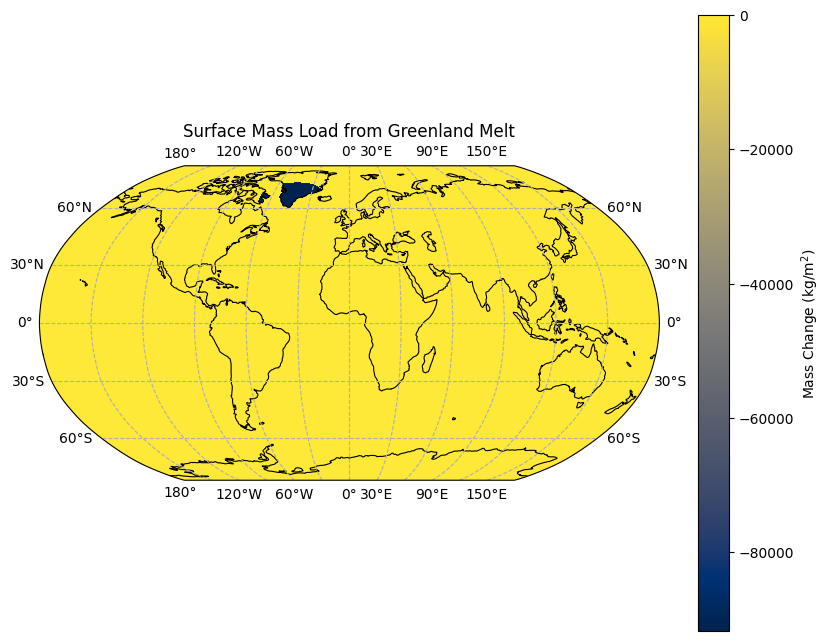

In [7]:
# Define the parameters for a disk load over Southern Greenland
lat_greenland, lon_greenland = 65.0, -45.0
radius_deg = 10.0
thickness_change_meters = -100.0

# Create a grid representing the change in ice thickness
ice_thickness_change = fp.disk_load(
    delta=radius_deg,
    latitude=lat_greenland,
    longitude=lon_greenland,
    amplitude=thickness_change_meters,
)

# Convert the ice thickness change into a surface mass load (in kg/m^2)
direct_load = fp.direct_load_from_ice_thickness_change(ice_thickness_change)

# Optional: Plot the load to see what it looks like
fig, ax, im = plot(direct_load, coasts=True, cmap='cividis')
ax.set_title("Surface Mass Load from Greenland Melt")
fig.colorbar(im, ax=ax, label="Mass Change (kg/m$^2$)")
plt.show()

## Step 2: Solving for All Output Fields

Now we run the solver, but this time we will capture all four of the output fields in separate variables. We will also print the change in angular velocity, which is returned as a simple NumPy array `[ω_x, ω_y]` representing the change in the x and y components of the Earth's rotation vector.

In [8]:
sea_level_change, displacement, gravity_potential_change, angular_velocity_change = fp(
    direct_load=direct_load
)

print(f"Change in angular velocity vector [ω_x, ω_y]: {angular_velocity_change}")

Change in angular velocity vector [ω_x, ω_y]: [ 4.61991976e-10 -3.80903109e-10]


## Step 3: Visualizing the Physical Fields

With all the results in hand, we can now plot them to understand the full physical response to the ice melt.

### Sea Level Change

First, we plot the sea-level fingerprint for our new Greenland load. As a reminder, this field represents the change in the sea surface equipotential (the geoid). We will again apply an ocean mask to focus the visualization on the world's oceans, but the underlying field is well-defined everywhere.

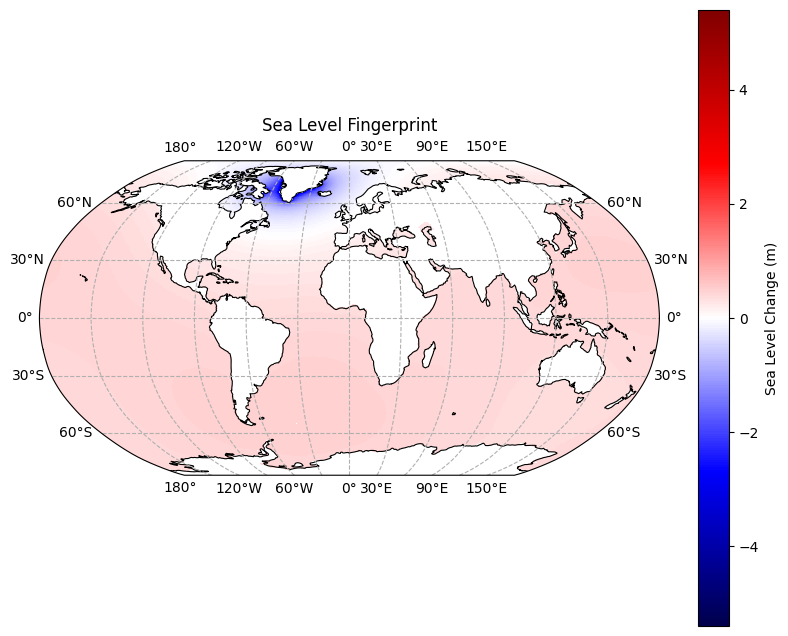

In [9]:
fig, ax, im = plot(
    sea_level_change * fp.ocean_projection(),
    coasts=True,
    cmap="seismic",
    symmetric=True
)
ax.set_title("Sea Level Fingerprint")
fig.colorbar(im, ax=ax, label="Sea Level Change (m)")
plt.show()

### Vertical Displacement

Next, we visualize the `displacement` field. This represents the **elastic deformation of the solid Earth**.

You should see a positive signal (uplift or "rebound") centered on the location where the ice was removed, as the crust is no longer weighed down. This uplift is surrounded by a weaker negative signal (subsidence), often called the "peripheral bulge." This deformation occurs on both land and the sea floor.

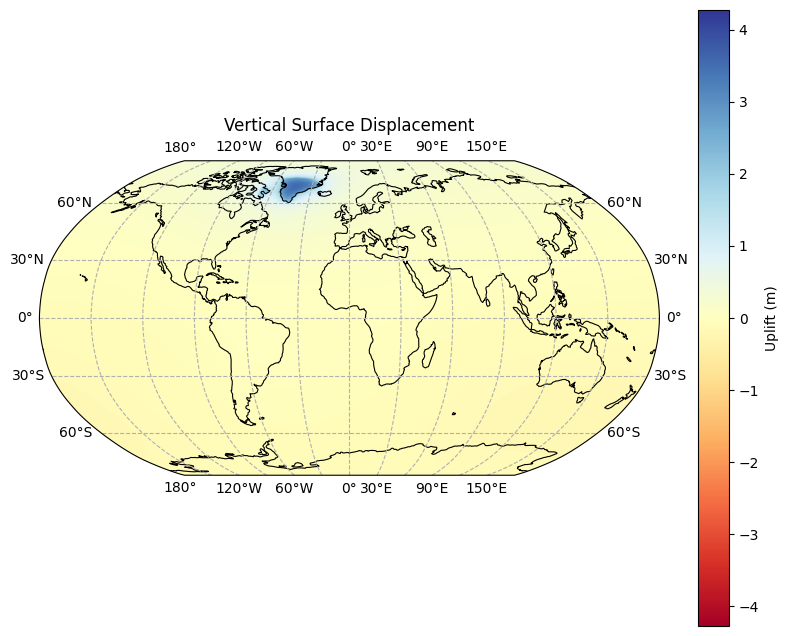

In [10]:
fig, ax, im = plot(
    displacement,
    coasts=True,
    cmap="RdYlBu",
    symmetric=True
)
ax.set_title("Vertical Surface Displacement")
fig.colorbar(im, ax=ax, label="Uplift (m)")
plt.show()

### Gravity and Gravitational Potential Change

It is important to distinguish between two related quantities:
* **Gravity Potential:** The potential experienced by an observer on the rotating Earth's surface. It includes the true **gravitational potential** (from mass) and the **centrifugal potential** (from rotation).
* **Gravitational Potential:** The potential due to mass alone. This is what a non-rotating observer or an orbiting satellite like GRACE would measure.

The `fp()` solver returns the total **`gravity_potential_change`**. For many applications, we want to isolate the pure **`gravitational_potential_change`**. The library provides a convenience method to perform this conversion, which subtracts the centrifugal potential component.

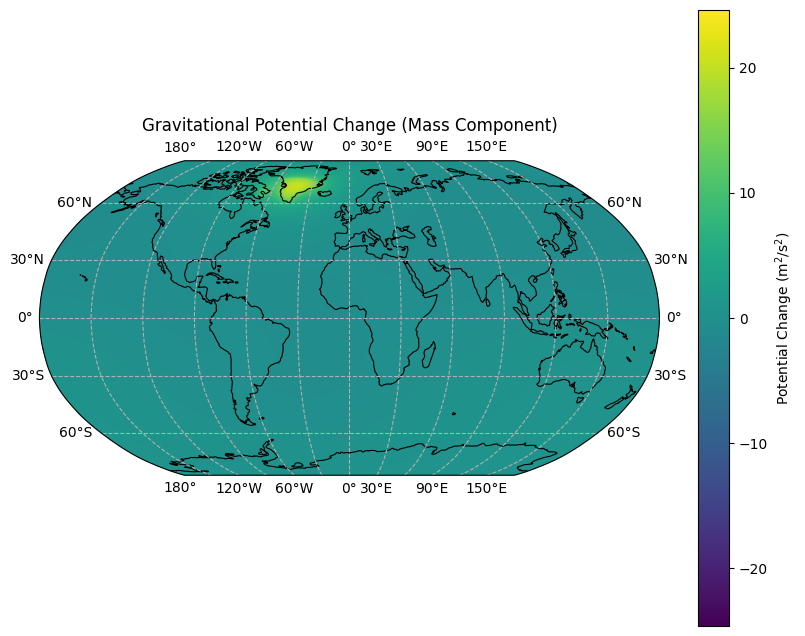

In [11]:
# Convert the total gravity potential change to pure gravitational potential change
gravitational_potential_change = fp.gravity_potential_change_to_gravitational_potential_change(
    gravity_potential_change, angular_velocity_change
)

# Plot the result
fig, ax, im = plot(
    gravitational_potential_change,
    coasts=True,
    cmap="viridis",
    symmetric=True
)
ax.set_title("Gravitational Potential Change (Mass Component)")
fig.colorbar(im, ax=ax, label="Potential Change (m$^2$/s$^2$)")
plt.show()

## Step 4: Investigating Rotational Feedbacks

The `pyslfp` solver includes the effect of **rotational feedbacks** by default. When a large mass is redistributed on the Earth's surface, it changes the planet's tensor of inertia, causing the rotation axis to shift slightly relative to the crust. This "polar wander" induces its own distinct, long-wavelength pattern of sea-level change.

We can investigate the importance of this effect by running the solver again with the `rotational_feedbacks` flag set to `False`. We can then subtract this new result from our original result to isolate the pure rotational signal.

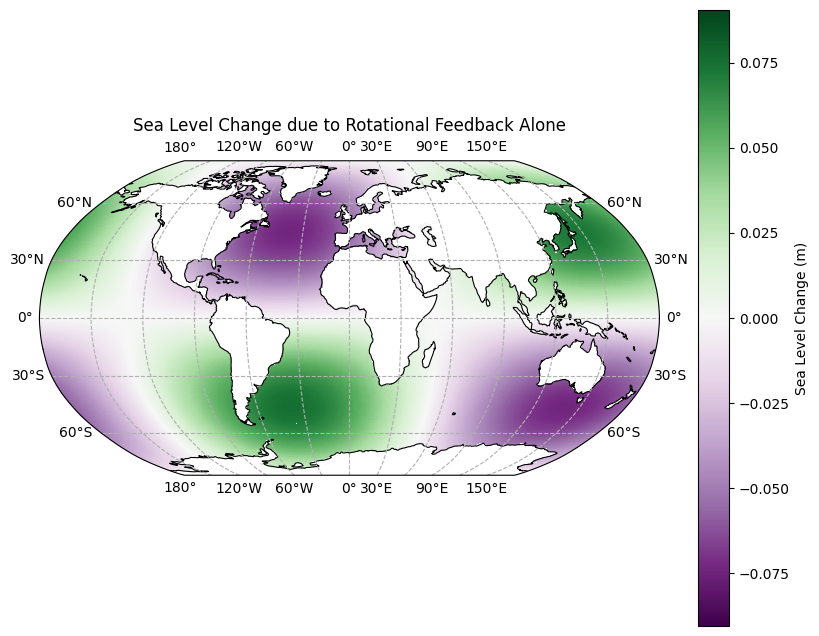

In [12]:
# Solve the sea level equation again, but with rotational feedbacks turned OFF
sea_level_no_rotation, _, _, _ = fp(
    direct_load=direct_load,
    rotational_feedbacks=False
)

# Calculate the difference to isolate the rotational effect
rotation_effect = sea_level_change - sea_level_no_rotation

# Plot the isolated rotational signal
fig, ax, im = plot(
    rotation_effect * fp.ocean_projection(),
    coasts=True,
    cmap="PRGn",
    symmetric=True
)
ax.set_title("Sea Level Change due to Rotational Feedback Alone")
fig.colorbar(im, ax=ax, label="Sea Level Change (m)")
plt.show()

## Advanced Topic: FingerPrint Initialization Options

The `FingerPrint` class can be initialized with several optional arguments for advanced customization. The most important are:
* `lmax`: Sets the spherical harmonic resolution (as we have seen).
* `grid`: Sets the `pyshtools` grid type. Common options include `'DH'` (Driscoll and Healy) and `'GLQ'` (Gauss-Legendre Quadrature). You can also use `'DH2'`, which is a Driscoll and Healy grid with double the number of samples in longitude for higher equatorial resolution. This is a standard `pyshtools` option, and the default is `'DH'`.
* `love_number_file`: Allows you to specify a path to a custom Love number file for a different Earth model.
* `earth_model_parameters`: Allows you to pass a custom `EarthModelParameters` object, giving you full control over the physical constants and the non-dimensionalization scheme.

### Non-Dimensionalisation Schemes
Internally, the library solves the equations using non-dimensional quantities. This is a standard technique in computational physics to improve numerical stability by ensuring all variables in the calculation have a similar order of magnitude (close to 1.0).

By default, `FingerPrint` uses a **trivial non-dimensionalization scheme** where all scales are set to 1.0, which is equivalent to working directly in SI units.

**Important Note:** The outputs of the solver (like `sea_level_change`) are returned in these non-dimensional units. The library **does not** automatically convert them back to SI units. When using the default (trivial) scheme, the outputs are in meters, m²/s², etc. However, if you use a custom scheme, you will need to re-scale your results manually for interpretation (e.g., multiply a non-dimensional length by the `length_scale`).

For most geophysical applications, the default SI-unit scheme is not recommended due to the large variation in the magnitude of physical constants. Instead, you can easily create a more sensible scheme using the `EarthModelParameters.from_standard_non_dimensionalisation()` static method, as shown in the code example below. This method uses the Earth's mean radius, the density of water, and one hour as the characteristic scales.